Predicting body fat percentage
------------

In order to highlight some of the power of the Jupyter Notebook I take some analysis performed by Mat Leonard (course developer at Udacity) on his [blog](http://matatat.org/body-fat-percentage.html) and converted to .ipynb worksheet adding commentary.

Background
-------------

For the past few months, I've been commuting to work on my bicycle. I've always been a walker, but I've been out of shape and slowly gaining fat for some time now. The new activity has led to some obvious weight loss. This has inspired me to keep working at it and track my progress. As part of this, I wanted to measure my percent body fat using tools I have around my apartment. You can find calculators out on the internet which give you a singular estimate. Being a scientist though, I want some knowledge of the uncertainty of the estimate. I decided to build my own model from data which I can use to get an estimate, with the uncertainty, of my body fat percentage.

I found data from a study which measured the body density and various anatomical measurements (such as neck and chest circumferences) of a group of men. From my research, I found that body density can be measured accurately using water or air displacement. However, it is unclear how to convert density into body fat percentage because you must assume a distribution of lean and fatty tissues. There are more than a few methods, but for this analysis I'm going to use Brozek's method.

Importing Packages
--------

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
sb.set_context("notebook", font_scale=1.25)

Reading Data
-------------


In [28]:
data = pd.read_csv('fat.dat.txt', delim_whitespace=True, header=None)
data.columns = ['case', 'pbf_b', 'pbf_s', 'density', 'age', 'weight', 
                'height', 'bmi','fat_free_w', 'neck', 'chest', 'abdomen', 
                'hip', 'thigh', 'knee', 'ankle','biceps', 'forearm', 'wrist']
data.index = data['case']
data = data.drop(['case', 'fat_free_w'], axis=1)
# Remove a few data points (outliers, incorrect values)
data = data.drop([42, 182])
data = data[data['weight']<300]

Now that the data is loaded, we can check it out. We'll look at the first few cases, then make some plots so we can see how some of the data is distributed. The first two columns are percent body fat (PBF) using the Brozek and Siri formula's, respectively. Every column from "neck" on is the circumference at those locations.

In [7]:
data.head()

,pbf_b,pbf_s,density,age,weight,height,bmi,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist
case,,,,,,,,,,,,,,,,,
1,12.6,12.3,1.0708,23,154.25,67.75,23.7,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
2,6.9,6.1,1.0853,22,173.25,72.25,23.4,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
3,24.6,25.3,1.0414,22,154.00,66.25,24.7,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
4,10.9,10.4,1.0751,26,184.75,72.25,24.9,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
5,27.8,28.7,1.0340,24,184.25,71.25,25.6,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


Exploring Basic Pairwise Trends
----------------

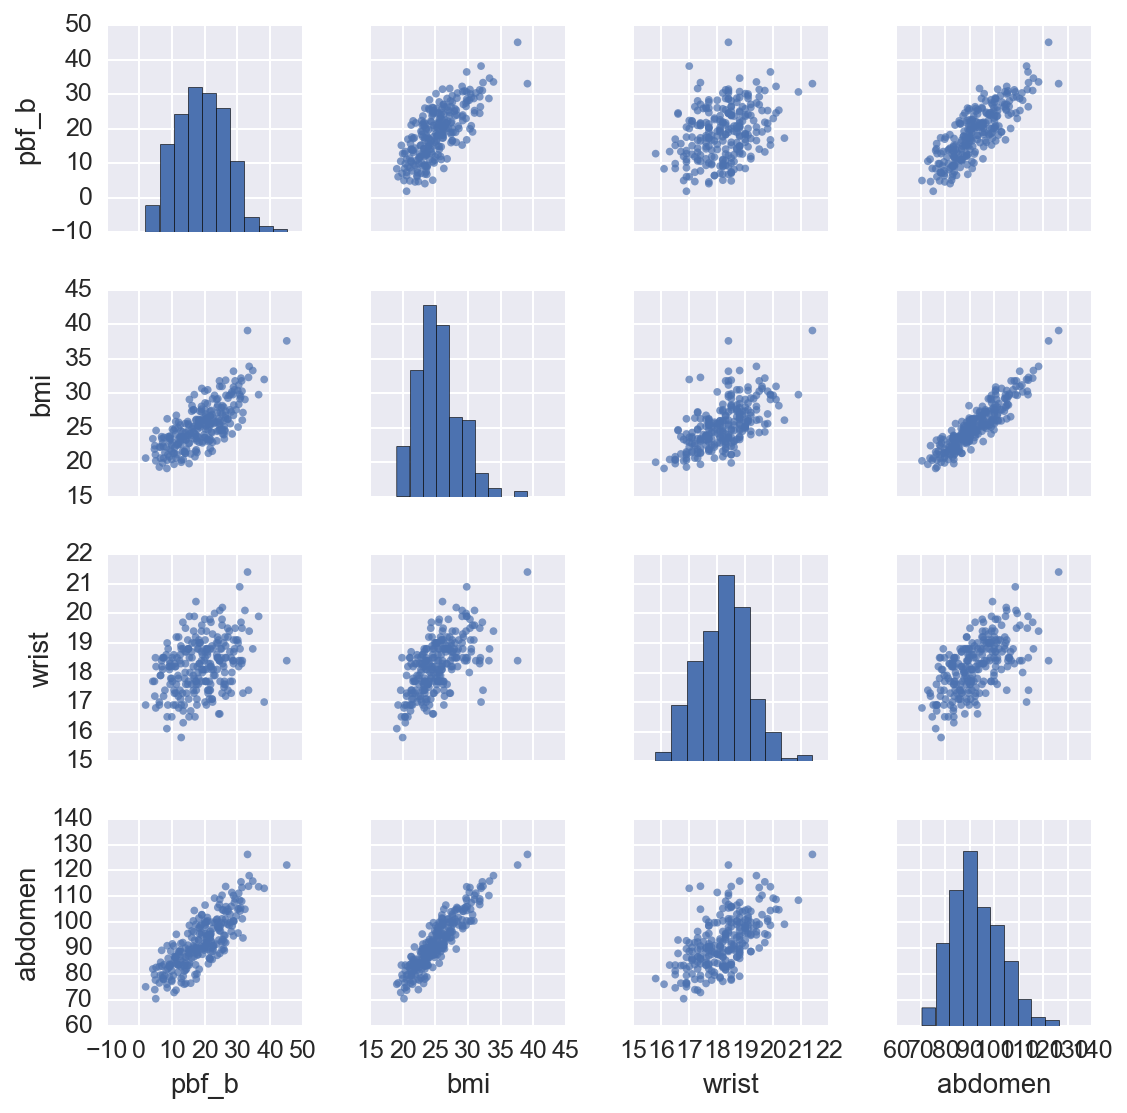

In [8]:
sb.pairplot(data[['pbf_b', 'bmi', 'wrist', 'abdomen']], 
                 size=2, plot_kws={'s':15,'edgecolor':'none','alpha':0.7})

From this we can see the percent body fat is correlated with weight and body measurements, while height has little if any effect. There are also correlations between body measurements and weight which we'll have to deal with later. I'm going to use a linear regression model to predict percent body fat from the data.

A linear regression model is a formal way to draw a line through a set of data points. For instance, we can see that when we plot abdomen circumference on the $x$-axis and percent body fat on the $y$-axis (first row, fifth column), the data falls along a general upward sloped line. As we would expect, a larger gut indicates more body fat. We can get a decent estimate of this relationship by printing out the plot and drawing a line through the data points by hand. However, we want to find the "best" line. What I mean by "best" is that the line we draw has the least error predicting the existing data points.


We can define any line using an intercept, $\beta_0$, and a slope, $\beta_1$, as $$y = \beta_0 + \beta_1 x$$.

Here, $y$ is our dependent variable, percent body fat for example, and $x$ is the independent variable, such as abdomen circumference. Depending on the context and conventions, $x$ is also called the explanatory variable, regressor, feature, predictor, and more. Our model is a prediction of the percent body fat $\hat y$ using the abdomen circumference $x$.


$$\hat y_i = \beta_0 + \beta_1 x_i$$

where the subscript $i$ indicates which data point we are using ($i=1$ is the first data point, and so on). Our goal here is to find values for $\beta_0$ and $\beta_1$ which give us the smallest error $\epsilon_i = y_i - \hat y_i$.

We find an exact solution to this problem if we minimize the sum of the squares of the errors,

$$SSE=\sum_{i=1}^n \vert y_i−\hat y_i \vert^2$$

We do this using the ordinary least squares method. Here I will use the excellent ```scikits``` learn Python package to fit a linear model to our data.

Least Squares
------------

In [9]:
from sklearn import linear_model

In [13]:
features = data[['abdomen']]

# Make an intercept column that is all 1
features.loc[:,'intercept'] = pd.Series(np.ones(len(features)), index=features.index)

# This is the part that fits the linear model to the data
linmodel = linear_model.LinearRegression(fit_intercept=False)
linmodel.fit(features, data['pbf_b'])


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [14]:
# And here I'll calculate the variances and print our results
var_e = linmodel.residues_/(len(data) - len(features.columns))
var_b = var_e*np.linalg.inv(np.dot(features.T, features)).diagonal()
print("Coefficients and standard dev.")
for feature, coef, var in zip(features.columns, linmodel.coef_, var_b):
    print('{}: {:.3f} +\- {:.3f}'.format(feature, coef, np.sqrt(var)))

Coefficients and standard dev.
abdomen: 0.616 +\- 0.027
intercept: -37.991 +\- 2.541


/Users/James/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


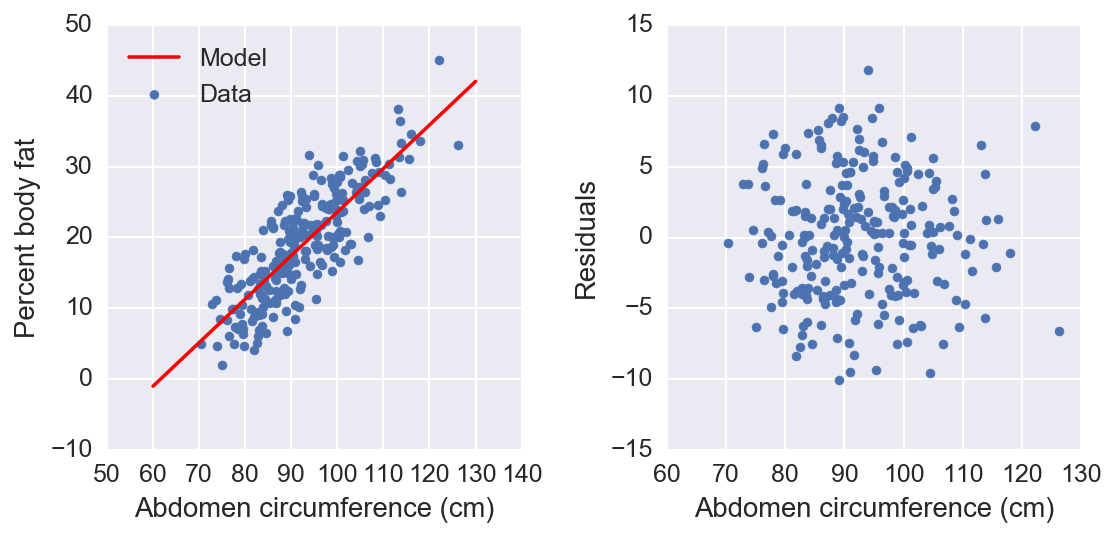

In [15]:
fig, (left, right) = plt.subplots(ncols=2, figsize=(8,4))
color = sb.color_palette('deep')[0]
left.scatter(data[['abdomen']], data[['pbf_b']], color=color, label='Data')
x = np.linspace(60, 130, 100)
left.plot(x, linmodel.coef_[1] + linmodel.coef_[0]*x, '-r', label='Model')
left.set_xlabel("Abdomen circumference (cm)")
left.set_ylabel("Percent body fat")
left.legend(loc='best')

y_hat = linmodel.coef_[1] + linmodel.coef_[0]*data[['abdomen']].values
residuals = data[['pbf_b']].values - y_hat
right.scatter(data[['abdomen']], residuals, color=color)
right.set_ylabel("Residuals")
_=right.set_xlabel("Abdomen circumference (cm)")
fig.tight_layout()

We see here that our model fits the data pretty well, but I'd like to measure the quality of the fit. A common way to measure the performance of the model is to split the data into a training set and a testing set. You fit the model to the training set, then measure how well it can predict the test set. This is known as cross-validation (CV) and is sort of the industry standard. I'll use ```scikits learn``` to perform $k$-folds CV. This method separates the data into $k$ parts (folds). Then, it uses $k−1$ folds to fit the model and then tests the model on the left out fold. Repeat this $k$ times using each fold to test only once.

In [16]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(linmodel, features, y=data['pbf_b'],
                         cv=5, scoring='mean_absolute_error')
print("Mean absolute error: {:.3f}".format(-scores.mean()))

Mean absolute error: 3.620


Multi-Variable Model
------------------

We can improve our model by including all the information we have in the data. Using a linear model makes this simple, we just add more coefficients. For each data point we have $m$ features and we can use them to predict the body fat percentage $\hat y$:

$$\hat y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i +\dots + \beta_m x_i = \sum_{i=1}^m \beta_j x_j$$

where the subscript $j$ indicates our data features and $x_0=1$.

For convenience, we can write our model in matrix notation:

$$\hat y = \mathbf X \beta$$.

$$\hat y = 
\left(
\begin{array}{c}
  y_1  \\
  y_2   \\
  \vdots \\
  y_n
\end{array}
\right)
\,\,\,\,\,
\beta = 
\left(
\begin{array}{c}
  \beta_1  \\
  \beta_2   \\
  \vdots \\
  \beta_n
\end{array}
\right)
\,\,\,\,\,
\mathbf{X} =
\left(
\begin{array}{ccccc}
1  & x_{1,1}  & x_{1,2} & \dots& x_{1,m}\\
1  & x_{2,1}  & x_{2,2} &  \dots & x_{2,m}\\
1  & \vdots & \vdots &  &\vdots \\
1  & x_{n,1}  & x_{n,2} & \dots & x_{m,n} 
\end{array}
\right)
 $$


Again, our error is $\mathbf{\epsilon} = \sum_{i=1}^{n} \left|\, y_i - \hat{y}_i \right|^2 $ which we want to minimize. There is an exact and unique solution for the coefficients that minimize the error:

$$\hat \beta = (X^TX)^{-1}X^Ty$$

In [18]:
features = data[['height', 'weight', 'age', 'neck', 'chest', 'abdomen', 
                 'hip', 'thigh', 'knee', 'ankle','biceps', 'forearm', 
                 'wrist']]
features.loc[:,'intercept'] = pd.Series(np.ones(len(features)), 
                                        index=features.index)

In [19]:
linmodel = linear_model.LinearRegression(fit_intercept=False)
linmodel.fit(features, data['pbf_b'])

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [20]:
scores = cross_val_score(linmodel, features, y=data['pbf_b'],
                         cv=5, scoring='mean_absolute_error')
var_e = linmodel.residues_/(len(data) - len(features.columns) - 1.)
var_b = var_e*np.linalg.inv(np.dot(features.T, features)).diagonal()
print("Coefficients and standard dev.")
for feature, coef, var in zip(features.columns, linmodel.coef_, var_b):
    print('{}: {:.3f} +\- {:.3f}'.format(feature, coef, np.sqrt(var)))
print("Mean absolute error: {:.3f}".format(-scores.mean()))

Coefficients and standard dev.
height: -0.248 +\- 0.178
weight: -0.006 +\- 0.063
age: 0.065 +\- 0.030
neck: -0.355 +\- 0.218
chest: -0.132 +\- 0.101
abdomen: 0.839 +\- 0.085
hip: -0.157 +\- 0.135
thigh: 0.151 +\- 0.137
knee: -0.070 +\- 0.227
ankle: 0.161 +\- 0.204
biceps: 0.164 +\- 0.158
forearm: 0.250 +\- 0.192
wrist: -1.663 +\- 0.494
intercept: 7.259 +\- 21.873
Mean absolute error: 3.353


/Users/James/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


Since we know that many of our features are correlated, we can use ridge regression to obtain a better prediction. Ridge regression is similar to normal linear regression, but we add a term to the error function that penalizes the size of the coefficients,

$$\epsilon = \sum_{i=1}^n \vert y_i− \hat y_i \vert^2 + \lambda \sum_j^m\beta^2_j$$

The penalty pulls the coefficients towards zero, a process known as shrinkage, and decreases the variance in the model, leading towards better predictions. The amount of shrinkage is controlled by the parameter $\lambda$, as $\lambda \rightarrow \infty$ all coefficients go to zero, and as $\lambda \rightarrow 0$ we get our normal linear regression. However, there is no way to know before hand what the best value for $\lambda$ is. I can find the best $\lambda$ by fitting a bunch of models with different $\lambda$ and choose the one with the least prediction error. This is typically done with (again) cross-validation and is available from ```scikits-learn```.

I'll also need to scale the features so that all the coefficients are on the same scale, and center the dependent variable as well.

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
scaled_features = StandardScaler().fit_transform(features)
target = data['pbf_b']-data['pbf_b'].mean()

ridge = linear_model.RidgeCV(alphas=np.logspace(-2,1,100), 
                             fit_intercept=False)
ridge.fit(scaled_features, target)
scores = cross_val_score(ridge, scaled_features, y=target,
                         cv=5, scoring='mean_absolute_error')

print("Coefficients")
for feature, coef, var in zip(features.columns, ridge.coef_, var_b):
    print('{}: {:.3f}'.format(feature, coef, np.sqrt(var)))
print("Mean absolute error: {:.3f}".format(-scores.mean()))

Coefficients
height: -0.736
weight: 0.094
age: 0.908
neck: -0.781
chest: -0.822
abdomen: 7.843
hip: -0.759
thigh: 0.717
knee: -0.153
ankle: 0.231
biceps: 0.430
forearm: 0.461
wrist: -1.529
intercept: 0.000
Mean absolute error: 3.302


Using ridge regression does improve our model a bit. However, I don't want to have to measure ten things every time I want to calculate my body fat. What I would like to do is find a small number of features that still give me a good prediction. A good method for this is lasso regression which is similar to ridge regression in that it penalizes the size of the coefficients, but instead of simply shrinking them, it sets coefficients to exactly zero. Here the error function is

$$\epsilon = \sum_{i=1}^n \vert y_i− \hat y_i \vert^2 + \lambda \sum_j^m\beta^2_j$$

We can see how the coefficients start at $0$ for large $\lambda$, then become non-zero as $\lambda$ is decreased.

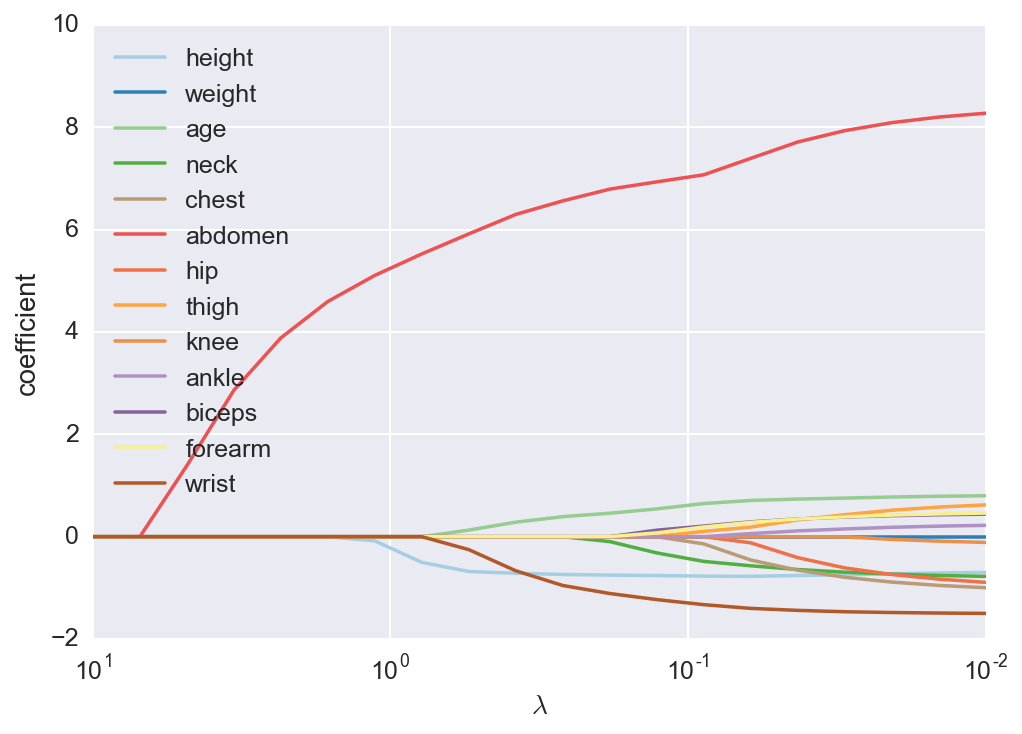

In [23]:
features = data[['height', 'weight', 'age', 'neck', 'chest', 'abdomen', 
                 'hip', 'thigh', 'knee', 'ankle', 'biceps', 'forearm', 
                 'wrist']]
scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features), 
                        index=features.index, columns=features.columns)
target = data['pbf_b']-data['pbf_b'].mean()

lambdas = np.logspace(1, -2, 20)
df = pd.DataFrame(index=features.columns, columns=lambdas)
for each in lambdas:
    lasso = linear_model.Lasso(alpha=each)
    lasso.fit(features, target)
    df[each] = lasso.coef_
df.T.plot(style='-', logx=True, colormap='Paired')
plt.xlabel('$\lambda$')
_ = plt.ylabel('coefficient')

We can see here that abdomen circumference is always a strong predictor. As $\lambda$ gets smaller, the coefficient for height becomes non-zero, then wrist circumference and age. I'm going to use these four features for my final model. It is reasonable that height and wrist circumference are negatively related to percent body fat. They indicate how long and how thick your bones are, respectively. Also, it seems that as one gets older, the percent body fat increases, holding everything else constant. I'm guessing this is from a change in the distribution of tissues, younger men having more muscle than older men. Now we can build a simpler model using only these features.

In [24]:
features = data[['height', 'age', 'abdomen', 'wrist']]

scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features), 
                        index=features.index, columns=features.columns)

target = data['pbf_b']-data['pbf_b'].mean()
ridge = linear_model.RidgeCV(alphas=np.logspace(-2,1), fit_intercept=False)
ridge.fit(features, target)
scores = cross_val_score(ridge, features, y=target,
                         cv=10, scoring='mean_absolute_error')
for feature, coef in zip(features.columns, ridge.coef_):
    print('{}: {:.3f}'.format(feature, coef))
print("Mean abs error: {:.3f}".format(-scores.mean()))

height: -0.794
age: 0.639
abdomen: 7.117
wrist: -1.571
Mean abs error: 3.291


Prediction
----------


Finally, I can predict my own body fat percentage. I'll use the CV error previously calculated as an estimate of the uncertainty.

In [27]:
measurements = [71, 31, 88, 17.5]
scaled = scaler.transform(measurements)
my_pbf = ridge.predict(scaled)+data['pbf_b'].mean()
print("My PBF = {} +/- {}".format(my_pbf, -scores.mean()))

My PBF = [ 16.16648387] +/- 3.29132724978


/Users/James/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/James/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
